# Thyroid Gland Dynamics

Implementation of [Kohanim et al.](https://pubmed.ncbi.nlm.nih.gov/35938225/)


 ### Function Parameters
 - $a_{i}$: removal rate of $i^*$
 - $b_{i}$: maximal $i$ secretion rate per unit thyroid mass
 - $f(TSH)$: TSH-regulation function (from Dietrich _et al_, 2012)
 - $P$ total mass of pituitary thyrotrophs
 - $u$ hypothalamic input
 - $T$ effective thyrocyte mass
 - $P$ pituitary thyrotroph mass

 *$i$ can refer to any of $TH$, $TSH$, $TRH$, $T$, or $P$

### ODEs

(1) $\frac{dTH}{dt} = b_{TH}Tf(TSH)-a_{TH}TH$ <br><br>
(2) $\frac{dTSH}{dt}=b_{TSH}P \frac{TRH}{TH}-a_{TSH}TSH$ <br><br>
(3) $\frac{dTRH}{dt}=b_{TRH} \frac{u}{TH}-a_{TRH}TRH$ <br><br>
(4) $\frac{dT}{dt} = T(b_Tf(TSH)(1-k_TT)-s_T)$ <br><br>
(5) $\frac{dP}{dt} = P(\frac{b_P(1-k_PP)}{(TH-a_P)})$ <br><br>

_Notes:_ $\frac{1}{TH}$ term in (2) approximates Michalis-Menten like term where $TH >> K$. Thyroid functional mass has turnover term $-a_TT$ and mass growth term $Tb_{T}f(TSH)$ and carrying capacity $\frac{1}{k_T}$

In [56]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import odeint

In [57]:
def initialize_params():
    # Simple steady state model
    u = 1
    a1 = 250
    b1 = 250
    a2 = 25
    b2 = 25
    a3 = 1/7
    b3 = 1/7
    kx2 = 0
    Ab = 0
    kT = 0
    at = 1/30
    bt = 1/30
    kP = 0
    ap = 1/30
    bp = 1/30

    params = [u,a1,b1,a2,b2,a3,b3,kx2,Ab,kT,at,bt,kP,ap,bp]
    return params

def Scaled_ICs(params):
    """Sets all parameters scaled such that SS value = 1"""
    u,a1,b1,a2,b2,a3,b3,kx2,Ab,kT,at,bt,kP,ap,bp = params
    x1 = (ap*b1*u)/a1*bp
    x2 = at/bt
    x3 = bp/ap
    T = (a3*bp*bt)/(ap*at*b3)
    P = (a1*a2*at*bp**2)/(ap**2*b1*b2*bt*u)
    return[x1,x2,x3,T,P]



In [68]:
# ODEs
def FTS(ICs,t,u,a1,b1,a2,b2,a3,b3,kx2,Ab,kT,at,bt,kP,ap,bp, dose=0):
    x1,x2,x3,T,P = ICs
    u,a1,b1,a2,b2,a3,b3,kx2,Ab,kT,at,bt,kP,ap,bp = params
    b30 = dose
    dx1dt = lambda t,b1,u,x3,a1,x1: (b1*u)/x3 - a1*x1
    dx2dt = lambda t,b2,P,x1,x3,a2,x2: (b2*P*x1)/x3 - a2*x2
    dx3dt = lambda t,b30,b3,T,Ab,x2,kx2,a3,x3: b30 + b3*T*(Ab+x2)/(1+kx2*(Ab+x2))-a3*x3
    dTdt  = lambda t,bt,kT,Ab,x2,kx2,at: T*(bt*(1-kT)*((Ab+x2)/(1+kx2*(Ab+x2)))-at)
    dPdt  = lambda t,P,bp,kP,x3,ap: P*((bp*(1-kP*P)/x3)-ap)

    dx1 = dx1dt(t,b1,u,x3,a1,x1)
    dx2 = dx2dt(t,b2,P,x1,x3,a2,x2)
    dx3 = dx3dt(t,b30,b3,T,Ab,x2,kx2,a3,x3)
    dT  = dTdt(t,bt,kT,Ab,x2,kx2,at)
    dP  = dPdt(t,P,bp,kP,x3,ap)

    return [dx1,dx2,dx3,dT,dP]

def use_odeint(IC, t, params):
    u,a1,b1,a2,b2,a3,b3,kx2,Ab,kT,at,bt,kP,ap,bp = params
    return odeint(FTS, IC, t, args=(u,a1,b1,a2,b2,a3,b3,kx2,Ab,kT,at,bt,kP,ap,bp))

params = initialize_params()
ICs = Scaled_ICs(params)
timespan = np.linspace(1,300,10000)

sol = use_odeint(ICs, timespan, params)
sol2 = use_odeint([4,3,2,5,3], timespan, params)

### Convergence of preturbed variables to scaled steady state 

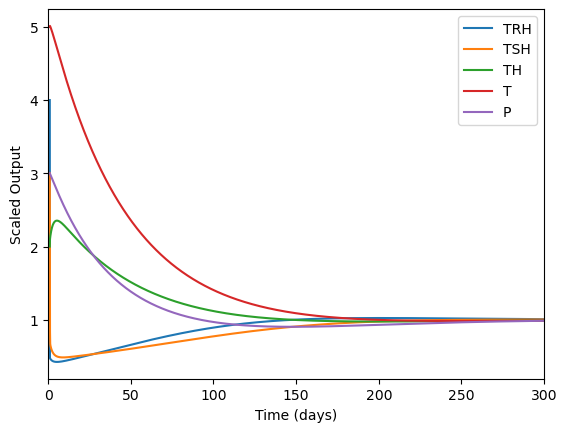

In [69]:
plt.plot(timespan, sol2, label = ['TRH', 'TSH', 'TH', 'T', 'P'])
plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Scaled Output')
plt.xlim(0,300)
plt.show()